In [1]:
import math

import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import scipy.special as special
from scipy.stats import poisson, uniform, norm
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from mpl_axes_aligner import align

import wf_func as wff

plt.style.use('default')
plt.rcParams['font.size'] = 20
plt.rcParams['text.usetex'] = False

import matplotlib
matplotlib.use('Agg')
%matplotlib inline

In [2]:
def my_cmap():
    plasma = cm.get_cmap('plasma', 65536)
    newcolors = plasma(np.linspace(0, 1, 65536))
    white = np.array([65535/65536, 65535/65536, 65535/65536, 1])
    newcolors[:1, :] = white
    newcmp = ListedColormap(newcolors)
    return newcmp

# 模拟中的时间分布

In [3]:
# methods = ['lucyddm', 'xiaopeip', 'takara', 'mcmcrec', 'fbmp']
methods = ['fbmp']

para = '10-20-10'
[npe, Tau, Sigma] = [int(i) for i in para.split('-')]
wf = h5py.File('waveform/' + para + '.h5', 'r', libver='latest', swmr=True)
spe_pre = wff.read_model('spe.h5')
p = spe_pre[0]['parameters']
mycmp = my_cmap()
colors = {'truth':'k', 'lucyddm':'g', 'xiaopeip':'b', 'takara':'y', 'mcmcrec':'r', 'fbmp':'m'}
t0 = wf['SimTruth/T']
pelist = wf['SimTriggerInfo/PEList']
wave = wf['Readout/Waveform']

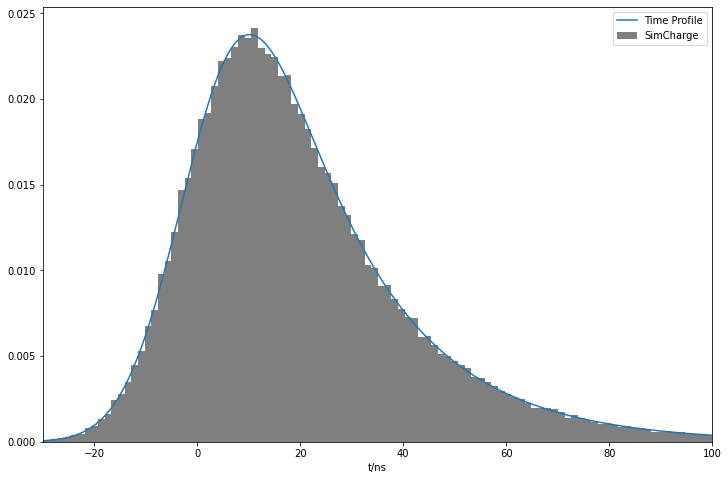

In [4]:
plt.close()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
t = np.arange(-40, 120, 0.1)
ax.plot(t, wff.convolve_exp_norm(t, Tau, Sigma), label='Time Profile')
ax.hist(pelist['HitPosInWindow'] - np.repeat(t0['T0'], np.unique(pelist['TriggerNo'], return_counts=True)[1]), bins=200, alpha=0.5, label='SimCharge', density=True, color=colors['truth'])
ax.set_xlim(-30, 100)
ax.legend()
ax.set_xlabel('t/ns')
plt.show()

# 模拟中的电荷分布

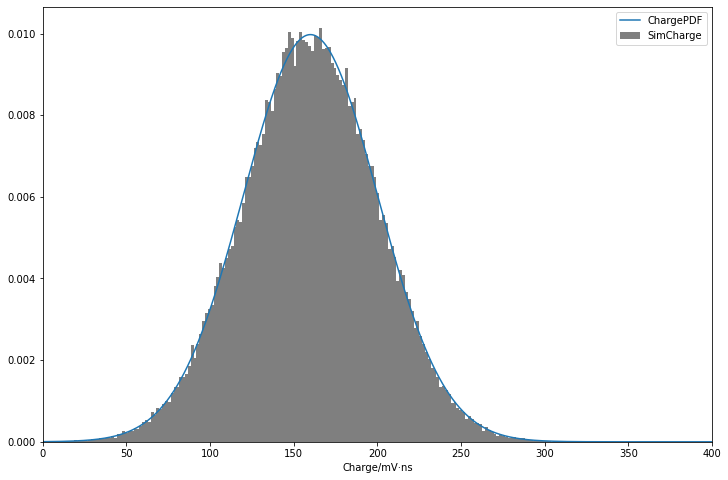

In [5]:
plt.close()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
t = np.arange(0, 1000, 0.1)
ax.plot(t, norm.pdf(t, loc=160., scale=40.) / (1 - norm.cdf(0, loc=160., scale=40.)), label='ChargePDF')
ax.hist(pelist['Charge'], bins=200, alpha=0.5, label='SimCharge', density=True, color=colors['truth'])
ax.set_xlim(0, 400)
ax.legend()
ax.set_xlabel('Charge/mV·ns')
plt.show()

# 重建结果的时间分布

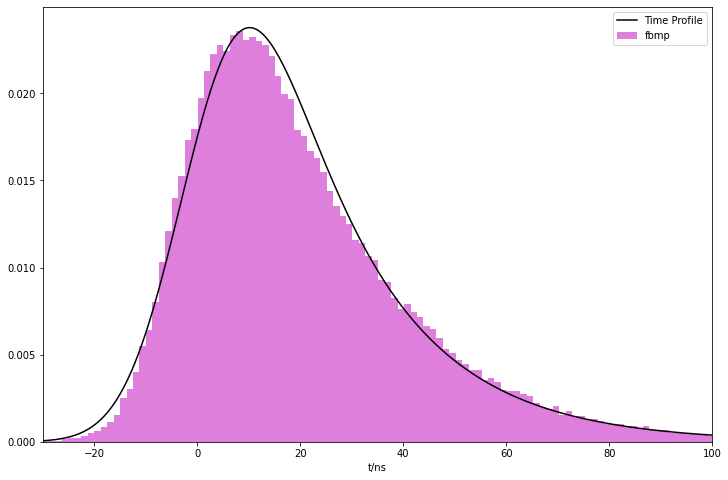

In [6]:
plt.close()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
t = np.arange(-40, 120, 0.1)
ax.plot(t, wff.convolve_exp_norm(t, Tau, Sigma), label='Time Profile', color=colors['truth'])
for m in methods:
    so = h5py.File('result/' + m + '/solu/' + para + '.h5', 'r', libver='latest', swmr=True)
    ch = h5py.File('result/' + m + '/char/' + para + '.h5', 'r', libver='latest', swmr=True)
    solut0 = so['starttime']
    chargepelist = ch['photoelectron']
    ax.hist(chargepelist['HitPosInWindow'] - np.repeat(solut0['tscharge'], np.unique(chargepelist['TriggerNo'], return_counts=True)[1]), bins=200, alpha=0.5, label=m, density=True, color=colors[m])
ax.set_xlim(-30, 100)
ax.legend()
ax.set_xlabel('t/ns')
plt.show()

# 重建结果的电荷分布

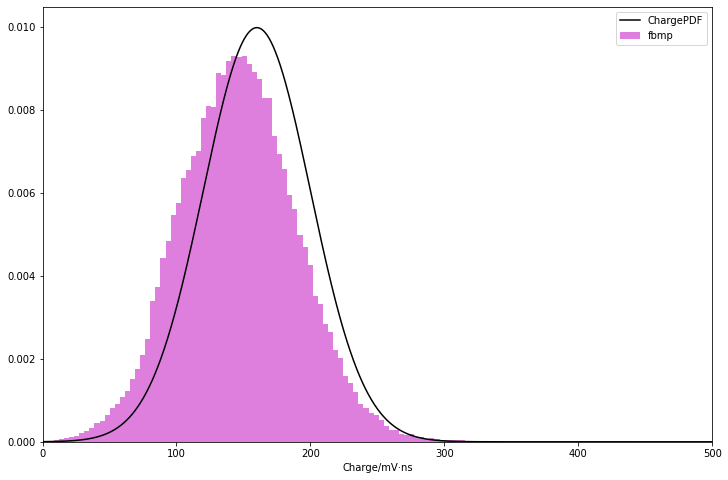

In [7]:
plt.close()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
t = np.arange(0, 1000, 0.1)
ax.plot(t, norm.pdf(t, loc=160., scale=40.) / (1 - norm.cdf(0, loc=160., scale=40.)), label='ChargePDF', color=colors['truth'])
for m in methods:
    ch = h5py.File('result/' + m + '/char/' + para + '.h5', 'r', libver='latest', swmr=True)
    ax.hist(ch['photoelectron']['Charge'], bins=100, alpha=0.5, label=m, density=True, color=colors[m])
ax.set_xlim(0, 500)
ax.legend()
ax.set_xlabel('Charge/mV·ns')
plt.show()

# 单事例分析

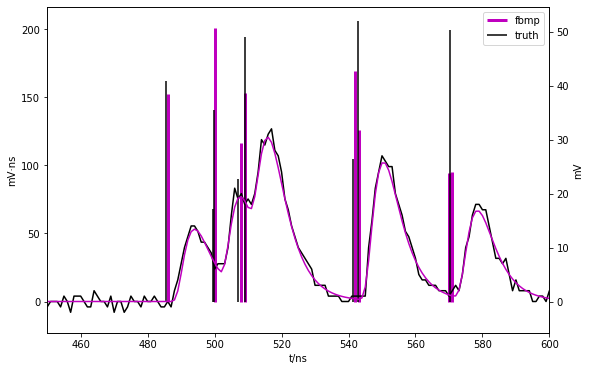

In [8]:
i = 0
pan = np.arange(len(wave[i]['Waveform']))
ind = np.argwhere(wave[i]['Waveform'] > spe_pre[0]['std'] * 5).flatten()
xmin = ((ind.min() - spe_pre[0]['mar_l']) // 50) * 50
xmax = max(((ind.max() + spe_pre[0]['mar_r']) // 50) * 50, xmin + 150)
plt.close()
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot()
truth = pelist[pelist['TriggerNo'] == i]
ax2 = ax.twinx()
ax2.plot(wave[i]['Waveform'], color=colors['truth'])
for m, mi in zip(methods, list(range(len(methods)))):
    ch = h5py.File('result/' + m + '/char/' + para + '.h5', 'r', libver='latest', swmr=True)
    charge = ch['photoelectron'][ch['photoelectron']['TriggerNo'] == i]
    wav_sub = np.sum([np.where(pan > charge['HitPosInWindow'][j], wff.spe(pan - charge['HitPosInWindow'][j], tau=p[0], sigma=p[1], A=p[2]) * charge['Charge'][j], 0) for j in range(len(charge['HitPosInWindow']))], axis=0) / np.sum(spe_pre[0]['spe'])
    ax.vlines(charge['HitPosInWindow'], ymin=0, ymax=charge['Charge'], label=m, color=colors[m], linewidth=3)
    ax2.plot(wav_sub, color=colors[m])
ax.vlines(truth['HitPosInWindow'], ymin=0, ymax=truth['Charge'], label='truth', color=colors['truth'])
ax.set_xlim(xmin, xmax)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)
align.yaxes(ax, 0, ax2, 0)
ax.set_xlabel('t/ns')
ax.set_ylabel('mV·ns')
ax2.set_ylabel('mV')
# plt.show()
plt.savefig('waveformdemo.png')

In [11]:
len(truth['HitPosInWindow']) - len(charge['HitPosInWindow'])

0

# 检查各方法的稀疏性

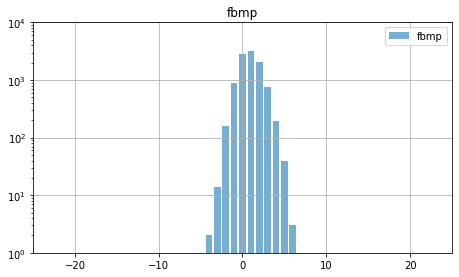

In [9]:
plt.close()
fig = plt.figure(figsize=(16, math.ceil(len(methods) / 2) * 4))
gs = gridspec.GridSpec(math.ceil(len(methods) / 2), 2, figure=fig, left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.25)
e_tru, i_tru = np.unique(pelist['TriggerNo'], return_index=True)
i_tru = np.append(i_tru, len(pelist))
for m, mi in zip(methods, list(range(len(methods)))):
    ch = h5py.File('result/' + m + '/char/' + para + '.h5', 'r', libver='latest', swmr=True)
    chargepelist = ch['photoelectron']
    e_cha, i_cha = np.unique(chargepelist['TriggerNo'], return_index=True)
    i_cha = np.append(i_cha, len(chargepelist))
    ax = fig.add_subplot(gs[mi // 2, mi % 2])
    di, ci = np.unique(np.diff(i_cha) - np.diff(i_tru), return_counts=True)
    ax.bar(di, ci, label=m, alpha=0.6, align='center')
    ax.legend()
    ax.set_title(m)
    ax.set_yscale('log')
    ax.set_ylim(1, 1e4)
    ax.set_xlim(-25, 25)
    ax.grid()

# 探索针对稀疏参数的优化方法